# IVUS Challenge

In this notebook we will investigate whether we need more data to feed into our model.

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import cv2
import random
import os
import keras
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
from skimage.metrics import hausdorff_distance
from skimage.measure import block_reduce


version = 4
seed = 123

2022-01-19 22:33:49.329498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12914206439023237174
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5031919616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1957605198675688537
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


2022-01-19 22:33:50.425658: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-19 22:33:50.427058: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-19 22:33:50.477447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 22:33:50.477841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 with Max-Q Design computeCapability: 6.1
coreClock: 1.48GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178

## Prepare the data

### Read the images
The images are stored in the <i>Training_Set</i> folder. We will load the images from <i>Data_set_A</i>:

An empirical number of five temporally adjacent frames around the frame $F$ (two before and two after) have been included. It has been considered when more than two frames forward (and backward) in time are considered, consecutive IVUS frames might not be aligned. 

-  A training set: A subset (one fourth) of images from each dataset containing both images and manual annotations. The training set is meant for training and tuning of the algorithms prior to the evaluation. This dataset is distributed upon request for algorithm evaluation.
- A test set: The remaining frames compose the set of images that are used for performance evaluation. The annotations are not available before the algorithm evaluation in order to assure the complete blindness and equity of the algorithm assessment.

Annotations on the image datasets have been provided by four clinical experts, daily working with the specific IVUS echograph brand, and belonging to distinct medical centers. The annotation consists in the delineation of both inner wall (lumen contours) and outer wall (media/adventitia contours) on the IVUS images in the short-axis view. In all the cases, the experts were blinded to the other physicians’ annotations, and two of them repeated the manual annotations after about one week from the first labeling.


In [3]:
# Helper functions
def read_labels(directory, verbose=1):
    """
    Reads the labels from a given directory
    
    returns:
        A dictionary containing:
            'lum': array of labels of 2D coordinates
            'med': array of labels of 2D coordinates
    """
    labels_lum = []
    labels_med = []

    for file_name in sorted(os.listdir(directory)):
        points = []
        with open(os.path.join(directory, file_name)) as f:
            for line in f:
                c0, c1 = line.split(',')
                points.append((float(c0), float(c1)))

        if file_name.startswith("lum"):
            labels_lum.append(points)
        elif file_name.startswith("med"):
            labels_med.append(points)
    
    # We will have imbalances since the number of coordinates is not fixed
    # To use numpy array, we will extend every list of labels repeating the last element
    labels_lum = np.array(labels_lum, dtype=object)
    if type(labels_lum[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_lum[i]) for i in range(len(labels_lum))])
        for i in range(len(labels_lum)):
            labels_lum[i] = np.concatenate(
                (labels_lum[i], np.repeat([labels_lum[i][-1]],m-len(labels_lum[i]), axis=0))
            )
    
    labels_med = np.array(labels_med, dtype=object)
    if type(labels_med[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_med[i]) for i in range(len(labels_med))])
        for i in range(len(labels_med)):
            labels_med[i] = np.concatenate(
                (labels_med[i], np.repeat([labels_med[i][-1]],m-len(labels_med[i]), axis=0))
            )

    # We have np.arrays inside np.arrays, we have to undo this
    labels = {
        'lum': np.array([l.tolist() for l in labels_lum]),
        'med': np.array([l.tolist() for l in labels_med])
    }

    if verbose:
        print(f"Annotation for the inner wall (lumen contours): {labels['lum'].shape}")
        print(f"Annotation for the outer wall (media/adventitia contours): {labels['med'].shape}")
        
    return labels

def read_training_dataset(letter="A", verbose=1):
    """
    Reads the training dataset A or B
    
    returns:
        Two tuples (x_train, y_train_label), (x_test, y_test_label):
            x_train: dataset of images for training
            y_train_label: a dictionary containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
            x_test: dataset of images for testing
            y_test_label: a list of 3 dictionaries containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
    """
    path = os.path.join(os.getcwd(), "Training_Set", "Data_set_"+letter, "DCM")

    dataset = []
    subset = []

    count = 0
    for file_name in sorted(os.listdir(path)):
        count += 1
        subset.append(cv2.imread(os.path.join(path, file_name), cv2.IMREAD_GRAYSCALE))

        if count >= 5:
            dataset.append(subset)
            subset = []
            count = 0

    dataset = np.array(dataset)
    
    if verbose:
        print(f"Dataset {letter} has shape: {dataset.shape}")
    
    # Read the labels
    y_train_labels = []
    y_train_directory = os.path.join(os.getcwd(), "Training_Set", "Data_set_"+letter, "LABELS")
    for dir_name in ['LABELS_obs1', 'LABELS_obs2_v1', 'LABELS_obs2_v2']:
        directory = os.path.join(y_train_directory, dir_name)
        y_train_labels.append(read_labels(directory, verbose))
    
    num_training_labels = y_train_labels[0]['lum'].shape[0]
    x_train = dataset[:num_training_labels, :, :, :]
    
    x_test = dataset[num_training_labels:, :, :, :]
    
    # Read test labels
    y_test_labels = []
    y_test_directory = os.path.join(os.getcwd(), "Test_Set", "Data_set_"+letter)
    for dir_name in ['LABELS_obs1', 'LABELS_obs2_v1', 'LABELS_obs2_v2']:
        directory = os.path.join(y_test_directory, dir_name)
        y_test_labels.append(read_labels(directory, verbose))
    
    return (x_train, y_train_labels), (x_test, y_test_labels)

In [4]:
(x_train, y_train_labels), (x_test, y_test_labels) = read_training_dataset("B")

Dataset B has shape: (435, 5, 384, 384)
Annotation for the inner wall (lumen contours): (109, 360, 2)
Annotation for the outer wall (media/adventitia contours): (109, 360, 2)
Annotation for the inner wall (lumen contours): (109, 471, 2)
Annotation for the outer wall (media/adventitia contours): (109, 568, 2)
Annotation for the inner wall (lumen contours): (109, 482, 2)
Annotation for the outer wall (media/adventitia contours): (109, 574, 2)
Annotation for the inner wall (lumen contours): (326, 360, 2)
Annotation for the outer wall (media/adventitia contours): (326, 360, 2)
Annotation for the inner wall (lumen contours): (326, 581, 2)
Annotation for the outer wall (media/adventitia contours): (326, 719, 2)
Annotation for the inner wall (lumen contours): (326, 583, 2)
Annotation for the outer wall (media/adventitia contours): (326, 720, 2)


#### Downsample images for better training
Now we will downsample our training and test dataset in order to be more memory-efficient when training. We must note that when we downsample by a half our images (from 384x384 to 192x192 in dataset B), then we need to divide by 2 our contour coordinates as well.

In [5]:
def downsample_image(image):
    """Downsample image by half by applying mean pooling"""
    return block_reduce(image, block_size=(2,2), func=np.mean)

In [6]:
x_train_ds = []
for batch in x_train:
    x_train_ds.append([downsample_image(image) for image in batch])

x_train_ds = np.array(x_train_ds)
y_train_label_ds = []
for label in y_train_labels:
    y_train_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

x_test_ds = []
for batch in x_test:
    x_test_ds.append([downsample_image(image) for image in batch])

x_test_ds = np.array(x_test_ds)
y_test_label_ds = []
for label in y_test_labels:
    y_test_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

print(f"Training set now has shape {x_train_ds.shape}")
print(f"Test set now has shape {x_test_ds.shape}")

Training set now has shape (109, 5, 192, 192)
Test set now has shape (326, 5, 192, 192)


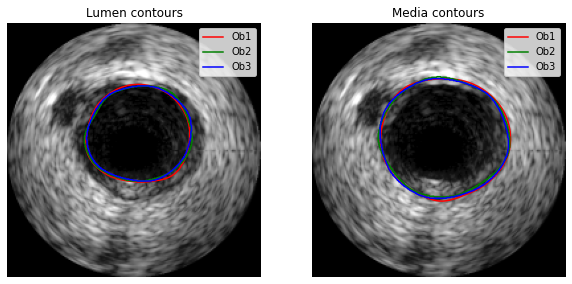

In [7]:
# Display some images
plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 2, 1)
plt.title("Lumen contours")
plt.plot(y_train_label_ds[0]['lum'][0][:, 0], y_train_label_ds[0]['lum'][0][:, 1], 'r-', label="Ob1")
plt.plot(y_train_label_ds[1]['lum'][0][:, 0], y_train_label_ds[1]['lum'][0][:, 1], 'g-', label="Ob2")
plt.plot(y_train_label_ds[2]['lum'][0][:, 0], y_train_label_ds[2]['lum'][0][:, 1], 'b-', label="Ob3")
plt.imshow(x_train_ds[0][2], cmap='gray')
plt.axis('off')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.title("Media contours")
plt.plot(y_train_label_ds[0]['med'][0][:, 0], y_train_label_ds[0]['med'][0][:, 1], 'r-', label="Ob1")
plt.plot(y_train_label_ds[1]['med'][0][:, 0], y_train_label_ds[1]['med'][0][:, 1], 'g-', label="Ob2")
plt.plot(y_train_label_ds[2]['med'][0][:, 0], y_train_label_ds[2]['med'][0][:, 1], 'b-', label="Ob3")
plt.imshow(x_train_ds[0][2], cmap='gray')
plt.axis('off')
plt.legend()

### Create a set of mask images
We will use the labels we have to mask the interior of the paths they draw. Since we have three different classes: background, media and lumen; we will create a multiclass segmentation.

In [8]:
num_observers = len(y_train_label_ds)
num_classes = 3
CLASSES = ['background', 'media', 'lumen']

In [9]:
def create_masks(x, y):
    """
    Create masks from a dataset and its labels
    
    parameters:
        x: dataset of images
        y: array of labels of 2D coordinates
    returns:
        An array containing multiclass images segmented as follows:
            - Value 0 represents background
            - Value 1 represents the media
            - Value 2 represents the lumen
    """
    
    masks = []

    for i in range(y['lum'].shape[0]):
        # Retrieve path from the label
        path_lum = Path(y['lum'][i])
        path_med = Path(y['med'][i])
        img = x[i][2]

        # Create a matrix of coordinates to check which points are inside the closed path
        img_meshgrid = np.array(np.meshgrid(*(np.arange(s) for s in img.shape[:2]), indexing='xy'))
        img_coordinates = img_meshgrid.transpose([1,2,0]).reshape(img.shape[0]*img.shape[1],2)
        mask_lum = path_lum.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])
        mask_med = path_med.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])

        final_mask = mask_lum.astype(int) + mask_med.astype(int)
        
        masks.append(final_mask)
        
    return np.array(masks)

def get_one_hot(targets, nb_classes):
    """Returns the targets as one-hot encoded"""
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### One-hot encoding
We one-hot encode our labels in the following way:
- Background pixels: [1, 0, 0]
- Media pixels: [0, 1, 0]
- Lumen pixels: [0, 0, 1]

This encoding will help optimize our model because we plan to output the probability of each pixel belonging to a certain class.

In [10]:
masks = np.concatenate(
    [create_masks(x_train_ds, observer_labels) for observer_labels in y_train_label_ds]
)
    
y_train_ds = get_one_hot(masks, num_classes)
x_train_ds = np.concatenate([x_train_ds for _ in range(num_observers)])

In [11]:
# GET TEST IMAGES
masks = np.concatenate(
    [create_masks(x_train_ds, observer_labels) for observer_labels in y_test_label_ds]
)
    
y_test_ds = get_one_hot(masks, num_classes)
x_test_ds = np.concatenate([x_test_ds for _ in range(num_observers)])

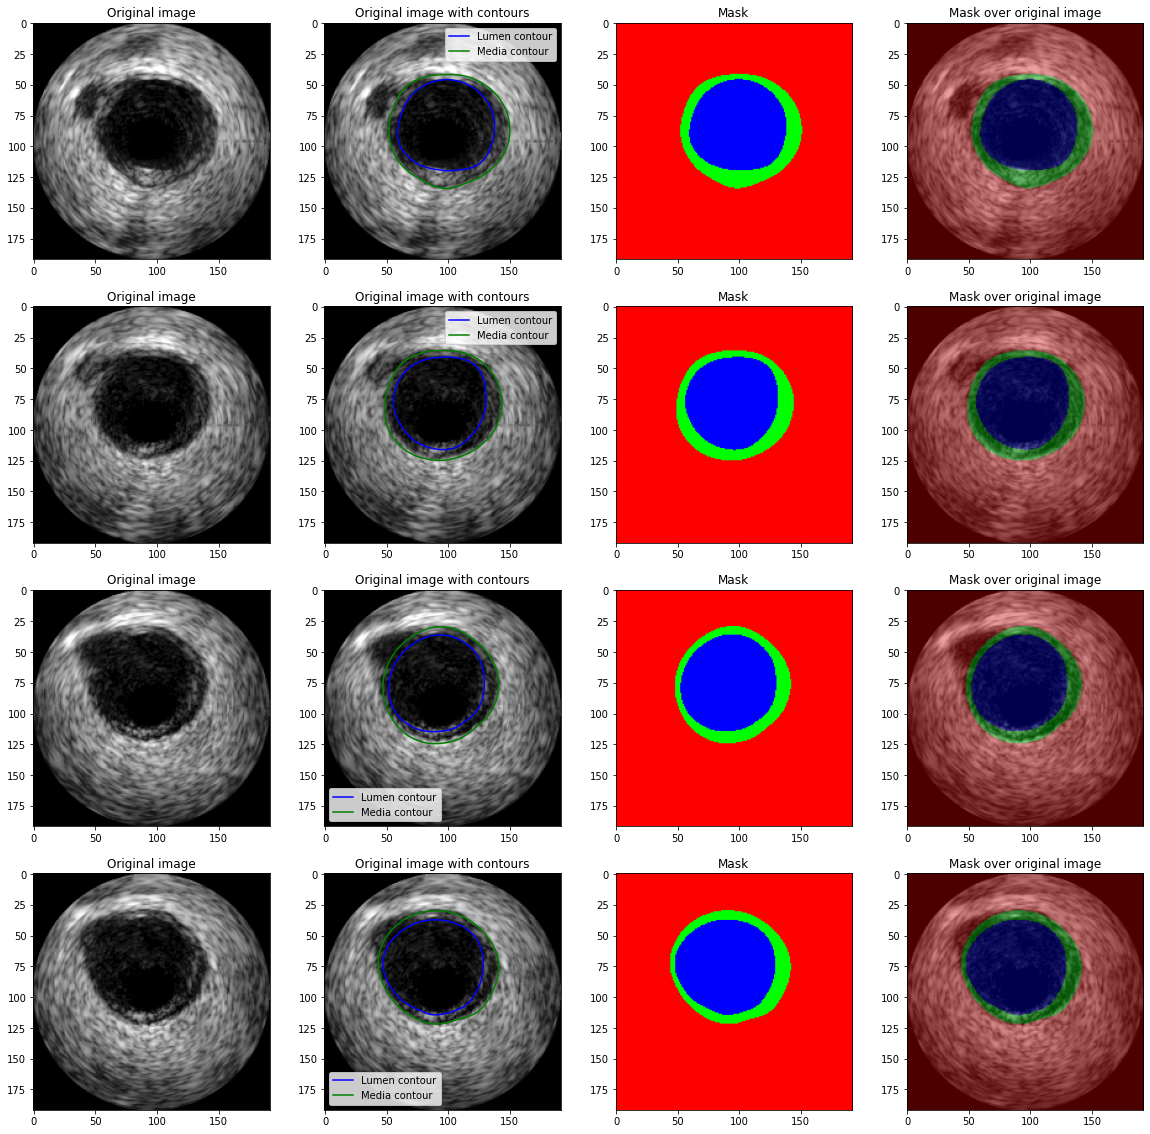

In [12]:
# Let's show some examples
plt.figure(figsize=(20, 20))

samples = 4

for i in range(samples):
    
    
    ax = plt.subplot(samples, 4, 4*i + 1)
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image')
    
    ax = plt.subplot(samples, 4, 4*i + 2)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-', label='Lumen contour')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-', label='Media contour')
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image with contours')
    plt.legend()
    
    
    mask = y_train_ds[i]/y_train_ds.max()
    ax = plt.subplot(samples, 4, 4*i + 3)
    plt.imshow(mask)
    plt.title('Mask')
    
    
    image = np.repeat(x_train_ds[i][2][..., np.newaxis], 3, axis=2)
    alpha = 0.7
    ax = plt.subplot(samples, 4, 4*i + 4)
    plt.imshow(np.uint8(image*alpha + mask*255*(1-alpha)))
    plt.title('Mask over original image')

### Data augmentation
We have 19 images to train using dataset A and 109 images in dataset B. Therefore we should apply Data Augmentation in order to get more training examples to feed into our model.

In this test we will only use the images adjacent to the middle image and we will pass these 3 images as 3 channels RGB to the data generator.

In [13]:
images = x_train_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (109, 192, 192, 3) (for dataset B)
masks = np.copy(y_train_ds) # Now the shape is (109, 384, 384, channels) (for dataset B)

print(f"Shape of set images: {images.shape}")
print(f"Shape of set masks: {masks.shape}")


input_shape = images.shape[1:] # (192, 192, 3)

Shape of set images: (327, 192, 192, 3)
Shape of set masks: (327, 192, 192, 3)


In [14]:
images_test = x_test_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (num_images, 192, 192, 3) (for dataset B)
masks_test = np.copy(y_test_ds) # Now the shape is (num_images, 192, 192, channels) (for dataset B)

    
print(f"Shape of set images_test: {images_test.shape}")
print(f"Shape of set masks_test: {masks_test.shape}")

Shape of set images_test: (978, 192, 192, 3)
Shape of set masks_test: (978, 192, 192, 3)


In [15]:
batch_size = 20

def get_image_generator(data_gen_args=dict(data_format="channels_last", validation_split=0.15),
                        images=images,
                        masks=masks,
                        batch_size=batch_size):
    # we create two instances with the same arguments
    val_data_gen_args = dict(
        data_format=data_gen_args['data_format'],
        validation_split=data_gen_args['validation_split']
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    val_datagen = ImageDataGenerator(**val_data_gen_args)

    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    # Provide the same seed and keyword arguments to the fit and flow methods
    image_generator = image_datagen.flow(images, seed=seed, batch_size=batch_size, subset='training')
    mask_generator = mask_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='training')

    image_val_generator = val_datagen.flow(images, seed=seed, batch_size=batch_size, subset='validation')
    mask_val_generator = val_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='validation')

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    val_generator = zip(image_val_generator, mask_val_generator)
    
    return train_generator, val_generator

def gen_dtype(gen):
    for i,j in gen:
        yield (i.astype('float32'), j.astype('float32'))

#def gen_dtype_test(gen):
#    for i,j in gen:
#        yield (i.astype('float32'), to_categorical(j.astype('int'), num_classes=num_classes))

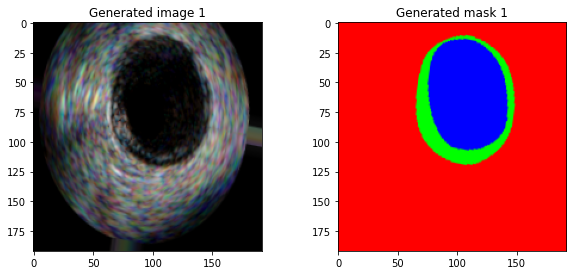

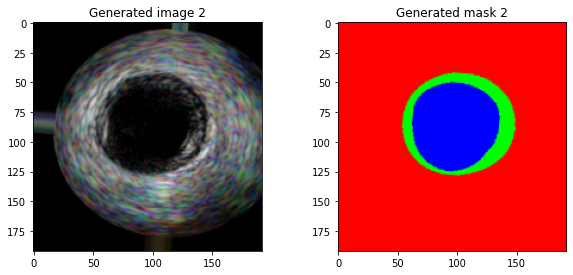

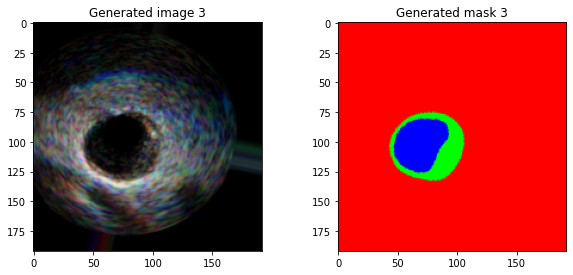

In [16]:
# Let's show some example
data_gen_args = dict(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0.15
)
train_generator, val_generator = get_image_generator(data_gen_args)
images_gen, masks_gen = next(gen_dtype(train_generator))
samples = len(images_gen)

for i in range(3):
    plt.figure(figsize=(10,100))
    plt.subplot(samples, 2, 2*i+1)
    plt.imshow(images_gen[i], cmap='gray')
    plt.title(f"Generated image {i+1}")
    
    plt.subplot(samples, 2, 2*i+2)
    plt.imshow(masks_gen[i])
    plt.title(f"Generated mask {i+1}")

## Transfer Learning with U-Net Inception (best performance)

### InceptionResNetV2

In [17]:
from Semantic_Segmentation_Architecture.TensorFlow.inception_resnetv2_unet import build_inception_resnetv2_unet
tf.keras.backend.clear_session()
inception_model = build_inception_resnetv2_unet(input_shape)
inception_model.summary()

2022-01-19 22:35:54.983749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 22:35:54.983893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 with Max-Q Design computeCapability: 6.1
coreClock: 1.48GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-19 22:35:54.983973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 22:35:54.984111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 22:35:54.984208: I tens

Model: "InceptionResNetV2_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 95, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 95, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(inception_model,to_file='inception_struct.png',show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.633118 to fit



Display layers status (trainable or non-trainable)

In [18]:
inception_layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
inception_model_df = pd.DataFrame(inception_layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(inception_model_df)

Layer Type  \
0    <tensorflow.python.keras.engine.input_layer.In...   
1    <tensorflow.python.keras.layers.convolutional....   
2    <tensorflow.python.keras.layers.normalization_...   
3    <tensorflow.python.keras.layers.core.Activatio...   
4    <tensorflow.python.keras.layers.convolutional....   
..                                                 ...   
633  <tensorflow.python.keras.layers.core.Activatio...   
634  <tensorflow.python.keras.layers.convolutional....   
635  <tensorflow.python.keras.layers.normalization_...   
636  <tensorflow.python.keras.layers.core.Activatio...   
637  <tensorflow.python.keras.layers.convolutional....   

                  Layer Name  Layer Trainable  
0                    input_1            False  
1                     conv2d            False  
2        batch_normalization            False  
3                 activation            False  
4                   conv2d_1            False  
..                       ...              ...  
633           activation_209             True  
634               conv2d_210             True  
635  batch_normalization_210             True  
636           activation_210             True  
637               conv2d_211             True  

[638 rows x 3 columns]

## Training the transfer learning U-Net model

In [18]:
# More helper functions

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)

def print_predictions(image, ground_truth, prediction, save_filename=None):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(ground_truth)
    
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.axis('off')
    plt.imshow(prediction) 
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", f"v{version}", "masks_prediction", save_filename))

def print_predictions_overlay(image, ground_truth, prediction, save_filename=None):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    handles = [
        mpatches.Patch(color='red', label='Ground Truth & Not Predicted'),
        mpatches.Patch(color='xkcd:green', label='Not Ground Truth & Predicted'),
        mpatches.Patch(color='blue', label='Ground Truth & Predicted')
    ]
    
    media_image = np.zeros(image.shape)
    media_image[:, :, 0][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==0)] = 1
    media_image[:, :, 1][(ground_truth[:, :, 1]==0) & (prediction[:, :, 1]==1)] = 1
    media_image[:, :, 2][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==1)] = 1
    plt.subplot(1, 3, 2)
    plt.title("Media mask")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(media_image)
    
    lumen_image = np.zeros(image.shape)
    lumen_image[:, :, 0][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==0)] = 1
    lumen_image[:, :, 1][(ground_truth[:, :, 2]==0) & (prediction[:, :, 2]==1)] = 1
    lumen_image[:, :, 2][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==1)] = 1
    plt.subplot(1, 3, 3)
    plt.title("Lumen mask")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(lumen_image)
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", f"v{version}", "masks_overlay", save_filename))

Define the loss and metrics functions

In [19]:
#calculates dice considering an input with a single class
def dice_single(true, pred, smooth=1.):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + smooth) / (true + pred + smooth)

def dice_for_class(index, smooth=1.):
    def dice_inner(true, pred):

        #get only the desired class
        true = true[:,:,:,index]
        pred = pred[:,:,:,index]

        #return dice per class
        return dice_single(true, pred, smooth)
    dice_inner.__name__ = f'dice_{CLASSES[index]}'
    return dice_inner

def dice_coef_loss(y_true, y_pred, smooth=1.):
    """
    Dice loss to minimize: 1 - Dice
    Dice = (2*|X & Y|)/ (|X| + |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    # Ignore label 0 which belongs to background
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred, axis=-1)
    denom = K.sum(y_true + y_pred, axis=-1)
    dice = K.mean(((2. * intersection + smooth) / (denom + smooth)))
    return 1 - dice

    
def jaccard_coef_loss(y_true, y_pred, smooth=1.):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    
    source code: 
    https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py
    
    Parameters
    -----------
    y_true : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    y_pred : Tensor
        The target distribution, format the same with `output`.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background),
            dice = ```smooth/(small_value + smooth)``,
            then if smooth is very small, dice close to 0 (even the image values lower than the threshold),
            so in this case, higher smooth can have a higher dice.
            
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

## Let's compare the different data augmentation

In [20]:
validation_split = 0.15
epochs = 20
steps_per_epoch = np.ceil(len(images)*(1-validation_split)/batch_size)
validation_steps = np.ceil(len(images)*validation_split/batch_size)

augmentations = [
    'No augmentation',
    'Horizontal & vertical flips',
    'Rotation',
    'Width & height shift',
    'Shear',
    'Zoom',
    'Shear & zoom',
    'Horizontal & vertical flips with rotation',
    'Width & height shift with shear & zoom',
    'All'
]
data_gen_args = [
    dict(
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        horizontal_flip=True,
        vertical_flip=True,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        rotation_range=90,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        width_shift_range=0.2,
        height_shift_range=0.2,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        shear_range=0.2,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        zoom_range=0.2,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        zoom_range=0.2,
        shear_range=0.2,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        data_format="channels_last",
        validation_split=validation_split
    ),
    dict(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        data_format="channels_last",
        validation_split=validation_split
    )
]

In [22]:
data = {}
for i in range(len(augmentations)):
    # Free up RAM in case the model definition cells were run multiple times
    K.clear_session()
    
    model = build_inception_resnetv2_unet(input_shape)
    
    # For each step: new_learning_rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=steps_per_epoch,
        decay_rate=0.7
    )
    optimizer = keras.optimizers.Adam(
        learning_rate=lr_schedule
    )
    loss = jaccard_coef_loss
    metrics = [dice_for_class(i) for i in range(num_classes)]
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    callbacks = [
        #keras.callbacks.ModelCheckpoint(f"ivus_segmentation_{model.name}_one-image.h5", save_best_only=True, verbose=1),
    ]
    
    train_generator, val_generator = get_image_generator(data_gen_args[i])
    
    # Train the model, doing validation at the end of each epoch.

    history = model.fit(
        gen_dtype(train_generator),
        validation_data=gen_dtype(val_generator),
        steps_per_epoch=steps_per_epoch,
        validation_steps = validation_steps,
        epochs=epochs,
        #callbacks=callbacks,
        verbose=1
    )
    
    ground_truth_masks_test = get_class_mask_from_prediction(masks_test)
    prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in model.predict(images_test)])

    # Obtain precision, recall, f1-score and support
    data[augmentations[i]] = classification_report(
        ground_truth_masks_test.flatten(),
        prediction_masks_test.flatten(),
        output_dict=True,
        target_names=['background', 'media', 'lumen']
    )
    # Save as dict in order to make it serializable
    data[augmentations[i]]['history'] = history.__dict__['history']

import json
json_dict = json.dumps(data)

with open(os.path.join(os.getcwd(), "output", f"v{version}", "augmentation_data.json"), 'w') as f:
    f.write(json_dict)

2022-01-13 18:25:24.080659: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-13 18:25:24.101379: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz


Epoch 1/20


2022-01-13 18:25:30.025615: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-13 18:25:30.348804: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-01-13 18:25:30.605144: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-13 18:25:30.605171: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-01-13 18:25:30.605539: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-13 18:25:30.605591: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-13 18:25:30.618411: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

13/14 [==========================>...] - ETA: 0s - loss: 0.2864 - dice_background: 0.7240 - dice_media: 0.0449 - dice_lumen: 0.5161

2022-01-13 18:25:47.372349: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-13 18:25:47.580609: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-13 18:25:47.842824: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-13 18:25:47.979789: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Alloc

14/14 [==============================] - 31s 1s/step - loss: 0.2790 - dice_background: 0.7346 - dice_media: 0.0524 - dice_lumen: 0.5296 - val_loss: 0.3065 - val_dice_background: 0.8204 - val_dice_media: 8.9492e-04 - val_dice_lumen: 0.5284
Epoch 2/20
14/14 [==============================] - 9s 676ms/step - loss: 0.1508 - dice_background: 0.8881 - dice_media: 0.6332 - dice_lumen: 0.5779 - val_loss: 0.2605 - val_dice_background: 0.8491 - val_dice_media: 7.2082e-04 - val_dice_lumen: 0.4922
Epoch 3/20
14/14 [==============================] - 9s 676ms/step - loss: 0.1347 - dice_background: 0.8903 - dice_media: 0.7711 - dice_lumen: 0.5441 - val_loss: 0.2642 - val_dice_background: 0.8466 - val_dice_media: 0.0052 - val_dice_lumen: 0.4786
Epoch 4/20
14/14 [==============================] - 9s 679ms/step - loss: 0.1299 - dice_background: 0.8911 - dice_media: 0.7693 - dice_lumen: 0.5500 - val_loss: 0.2465 - val_dice_background: 0.8822 - val_dice_media: 0.0835 - val_dice_lumen: 0.5008
Epoch 5/20
14

2022-01-13 18:28:56.878224: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.
2022-01-13 18:29:13.677913: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


Epoch 1/20
14/14 [==============================] - 17s 814ms/step - loss: 0.2716 - dice_background: 0.7508 - dice_media: 0.1645 - dice_lumen: 0.6990 - val_loss: 0.3512 - val_dice_background: 0.7501 - val_dice_media: 0.1174 - val_dice_lumen: 0.8587
Epoch 2/20
14/14 [==============================] - 9s 678ms/step - loss: 0.1698 - dice_background: 0.8497 - dice_media: 0.3336 - dice_lumen: 0.9376 - val_loss: 0.2323 - val_dice_background: 0.8299 - val_dice_media: 0.2253 - val_dice_lumen: 0.8994
Epoch 3/20
14/14 [==============================] - 9s 679ms/step - loss: 0.1617 - dice_background: 0.8509 - dice_media: 0.3419 - dice_lumen: 0.9414 - val_loss: 0.2250 - val_dice_background: 0.8384 - val_dice_media: 0.2410 - val_dice_lumen: 0.8940
Epoch 4/20
14/14 [==============================] - 9s 679ms/step - loss: 0.1580 - dice_background: 0.8517 - dice_media: 0.3494 - dice_lumen: 0.9455 - val_loss: 0.2073 - val_dice_background: 0.8464 - val_dice_media: 0.2957 - val_dice_lumen: 0.9158
Epoch 5

2022-01-13 18:33:26.084421: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.
2022-01-13 18:33:39.851772: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.


Epoch 1/20
14/14 [==============================] - 19s 885ms/step - loss: 0.3208 - dice_background: 0.7586 - dice_media: 0.3529 - dice_lumen: 9.7606e-04 - val_loss: 0.6151 - val_dice_background: 3.3176e-05 - val_dice_media: 0.1354 - val_dice_lumen: 2.5384e-04
Epoch 2/20
14/14 [==============================] - 10s 687ms/step - loss: 0.1767 - dice_background: 0.9835 - dice_media: 0.5251 - dice_lumen: 2.9667e-04 - val_loss: 0.5191 - val_dice_background: 0.1955 - val_dice_media: 0.2129 - val_dice_lumen: 2.4874e-04
Epoch 3/20
14/14 [==============================] - 10s 688ms/step - loss: 0.1473 - dice_background: 0.9900 - dice_media: 0.5412 - dice_lumen: 2.9667e-04 - val_loss: 0.4478 - val_dice_background: 0.6914 - val_dice_media: 0.2643 - val_dice_lumen: 2.5183e-04
Epoch 4/20
14/14 [==============================] - 10s 689ms/step - loss: 0.1342 - dice_background: 0.9920 - dice_media: 0.5477 - dice_lumen: 2.9667e-04 - val_loss: 0.3627 - val_dice_background: 0.8367 - val_dice_media: 0.35

2022-01-13 18:38:09.287287: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 432635904 exceeds 10% of free system memory.
/home/annon20/Documents/UB/TFG/tfg-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/annon20/Documents/UB/TFG/tfg-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/annon20/Documents/UB/TFG/tfg-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Epoch 1/20
14/14 [==============================] - 20s 873ms/step - loss: 0.2205 - dice_background: 0.8327 - dice_media: 0.0020 - dice_lumen: 0.6154 - val_loss: 0.5909 - val_dice_background: 3.3176e-05 - val_dice_media: 3.8020e-04 - val_dice_lumen: 0.1977
Epoch 2/20
14/14 [==============================] - 10s 715ms/step - loss: 0.0807 - dice_background: 0.9897 - dice_media: 0.3295 - dice_lumen: 0.8416 - val_loss: 0.5417 - val_dice_background: 0.0056 - val_dice_media: 3.8690e-04 - val_dice_lumen: 0.2183
Epoch 3/20
14/14 [==============================] - 9s 679ms/step - loss: 0.0499 - dice_background: 0.9918 - dice_media: 0.8121 - dice_lumen: 0.9315 - val_loss: 0.4602 - val_dice_background: 0.3198 - val_dice_media: 3.8084e-04 - val_dice_lumen: 0.3276
Epoch 4/20
14/14 [==============================] - 9s 682ms/step - loss: 0.0404 - dice_background: 0.9929 - dice_media: 0.8336 - dice_lumen: 0.9413 - val_loss: 0.3497 - val_dice_background: 0.7840 - val_dice_media: 0.0430 - val_dice_lume

Epoch 14/20
14/14 [==============================] - 10s 726ms/step - loss: 0.1204 - dice_background: 0.8924 - dice_media: 0.4193 - dice_lumen: 0.9592 - val_loss: 0.1271 - val_dice_background: 0.8918 - val_dice_media: 0.4252 - val_dice_lumen: 0.9568
Epoch 15/20
14/14 [==============================] - 10s 721ms/step - loss: 0.1202 - dice_background: 0.8925 - dice_media: 0.4212 - dice_lumen: 0.9601 - val_loss: 0.1263 - val_dice_background: 0.8914 - val_dice_media: 0.4286 - val_dice_lumen: 0.9555
Epoch 16/20
14/14 [==============================] - 10s 739ms/step - loss: 0.1202 - dice_background: 0.8925 - dice_media: 0.4214 - dice_lumen: 0.9603 - val_loss: 0.1253 - val_dice_background: 0.8916 - val_dice_media: 0.4263 - val_dice_lumen: 0.9547
Epoch 17/20
14/14 [==============================] - 10s 745ms/step - loss: 0.1202 - dice_background: 0.8926 - dice_media: 0.4211 - dice_lumen: 0.9603 - val_loss: 0.1246 - val_dice_background: 0.8916 - val_dice_media: 0.4286 - val_dice_lumen: 0.9538


Epoch 7/20
14/14 [==============================] - 10s 733ms/step - loss: 0.1418 - dice_background: 0.8521 - dice_media: 0.4676 - dice_lumen: 0.9458 - val_loss: 0.1766 - val_dice_background: 0.8516 - val_dice_media: 0.6555 - val_dice_lumen: 0.9097
Epoch 8/20
14/14 [==============================] - 10s 709ms/step - loss: 0.1321 - dice_background: 0.8522 - dice_media: 0.7139 - dice_lumen: 0.9521 - val_loss: 0.1594 - val_dice_background: 0.8512 - val_dice_media: 0.7684 - val_dice_lumen: 0.9231
Epoch 9/20
14/14 [==============================] - 10s 682ms/step - loss: 0.1252 - dice_background: 0.8537 - dice_media: 0.8021 - dice_lumen: 0.9530 - val_loss: 0.1447 - val_dice_background: 0.8520 - val_dice_media: 0.8364 - val_dice_lumen: 0.9478
Epoch 10/20
14/14 [==============================] - 10s 682ms/step - loss: 0.1203 - dice_background: 0.8559 - dice_media: 0.8323 - dice_lumen: 0.9535 - val_loss: 0.1373 - val_dice_background: 0.8527 - val_dice_media: 0.8274 - val_dice_lumen: 0.9435
Epo

Epoch 20/20
14/14 [==============================] - 10s 715ms/step - loss: 0.1301 - dice_background: 0.8912 - dice_media: 0.4115 - dice_lumen: 0.9495 - val_loss: 0.1348 - val_dice_background: 0.8911 - val_dice_media: 0.4253 - val_dice_lumen: 0.9254
Epoch 1/20
14/14 [==============================] - 19s 834ms/step - loss: 0.1971 - dice_background: 0.8754 - dice_media: 0.0041 - dice_lumen: 0.6125 - val_loss: 0.5885 - val_dice_background: 3.3176e-05 - val_dice_media: 0.0048 - val_dice_lumen: 0.2706
Epoch 2/20
14/14 [==============================] - 10s 687ms/step - loss: 0.0682 - dice_background: 0.9874 - dice_media: 0.3859 - dice_lumen: 0.8533 - val_loss: 0.5123 - val_dice_background: 0.0571 - val_dice_media: 3.8690e-04 - val_dice_lumen: 0.2491
Epoch 3/20
14/14 [==============================] - 10s 709ms/step - loss: 0.0420 - dice_background: 0.9910 - dice_media: 0.8016 - dice_lumen: 0.9346 - val_loss: 0.4372 - val_dice_background: 0.3741 - val_dice_media: 3.8084e-04 - val_dice_lumen

Epoch 13/20
14/14 [==============================] - 10s 702ms/step - loss: 0.0503 - dice_background: 0.9927 - dice_media: 0.8377 - dice_lumen: 0.9421 - val_loss: 0.0678 - val_dice_background: 0.9927 - val_dice_media: 0.8324 - val_dice_lumen: 0.9497
Epoch 14/20
14/14 [==============================] - 10s 710ms/step - loss: 0.0503 - dice_background: 0.9923 - dice_media: 0.8332 - dice_lumen: 0.9408 - val_loss: 0.0647 - val_dice_background: 0.9928 - val_dice_media: 0.8352 - val_dice_lumen: 0.9454
Epoch 15/20
14/14 [==============================] - 10s 683ms/step - loss: 0.0499 - dice_background: 0.9924 - dice_media: 0.8364 - dice_lumen: 0.9423 - val_loss: 0.0636 - val_dice_background: 0.9923 - val_dice_media: 0.8221 - val_dice_lumen: 0.9391
Epoch 16/20
14/14 [==============================] - 10s 684ms/step - loss: 0.0500 - dice_background: 0.9925 - dice_media: 0.8349 - dice_lumen: 0.9411 - val_loss: 0.0611 - val_dice_background: 0.9925 - val_dice_media: 0.8255 - val_dice_lumen: 0.9408


In [21]:
import json

with open(os.path.join(os.getcwd(), "output", f"v{version}", "augmentation_data.json"), 'r') as f:
    data = json.load(f)

In [28]:
data['Rotation']

{'background': {'precision': 0.9894618532395437,
  'recall': 0.98358242217203,
  'f1-score': 0.9865133777123826,
  'support': 30795773},
 'media': {'precision': 0.3754745451875103,
  'recall': 0.867833657497453,
  'f1-score': 0.5241652023908272,
  'support': 2353746},
 'lumen': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2903473},
 'accuracy': 0.8968143614821206,
 'macro avg': {'precision': 0.45497879947568465,
  'recall': 0.617138693223161,
  'f1-score': 0.50355952670107,
  'support': 36052992},
 'weighted avg': {'precision': 0.8696924331096078,
  'recall': 0.8968143614821206,
  'f1-score': 0.8768812804762609,
  'support': 36052992},
 'history': {'loss': [0.32081204652786255,
   0.1767297238111496,
   0.1473167985677719,
   0.13418538868427277,
   0.1268642097711563,
   0.12241094559431076,
   0.11951825022697449,
   0.11783189326524734,
   0.11660398542881012,
   0.11557433754205704,
   0.11499837785959244,
   0.11448924988508224,
   0.114240862429142,
   0.11

### f1-scores for each different data augmentation

In [31]:
def bar_chart_with_colors(heights, labels, color_by_label, title, xlabel, ylabel, ylim=None):
    plt.figure()
    plt.xticks(range(len(labels)))
    barlist = plt.bar(range(len(labels)), heights)
    for i in range(len(barlist)):
        barlist[i].set_color(color_by_label[labels[i]])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    handles = [plt.Rectangle((0,0),1,1, color=color_by_label[label]) for label in labels]
    plt.legend(handles, labels, bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

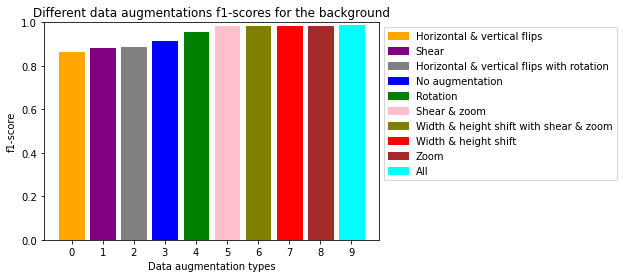

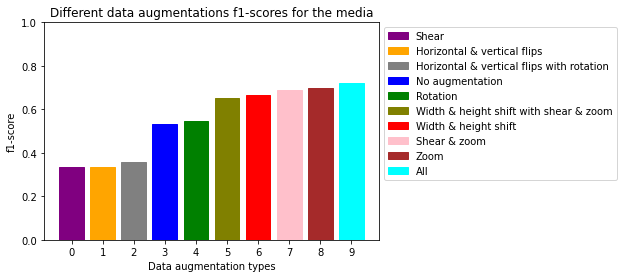

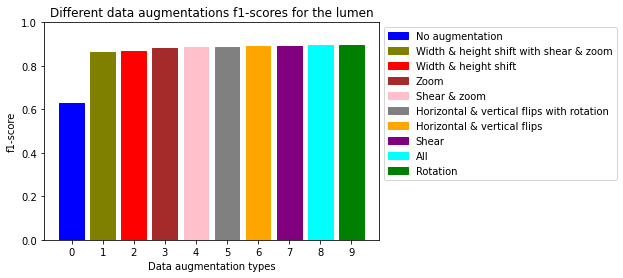

In [32]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray','olive', 'cyan']
color_by_label = {list(data.keys())[i]: colors[i] for i in range(len(data.keys()))}
classes = ['background', 'media', 'lumen']
for class_name in classes: 
    f1_scores = [(key, data[key][class_name]['f1-score']) for key in data.keys()]
    f1_scores = np.array(sorted(f1_scores, key=lambda x: x[1]), dtype=object)

    bar_chart_with_colors(
        f1_scores[:, 1],
        f1_scores[:, 0],
        color_by_label=color_by_label,
        title="Different data augmentations f1-scores for the " + class_name,
        xlabel="Data augmentation types",
        ylabel="f1-score",
        ylim=[0,1]
    )

### Recall scores for each data augmentation

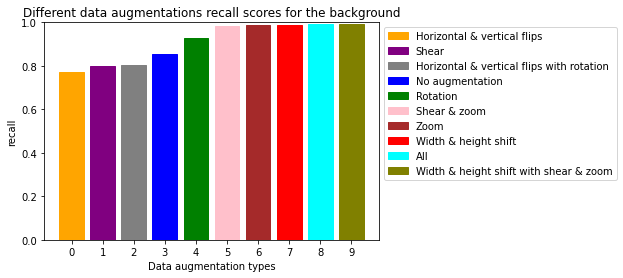

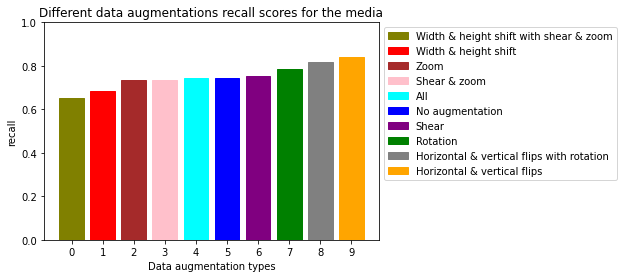

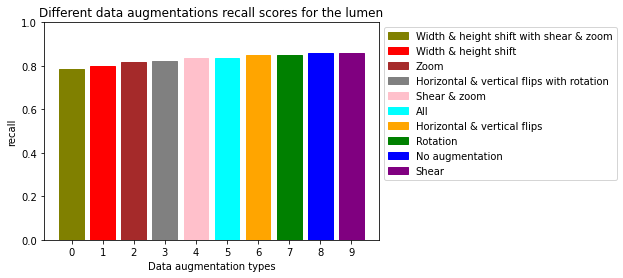

In [33]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray','olive', 'cyan']
color_by_label = {list(data.keys())[i]: colors[i] for i in range(len(data.keys()))}
classes = ['background', 'media', 'lumen']
for class_name in classes: 
    recall_scores = [(key, data[key][class_name]['recall']) for key in data.keys()]
    recall_scores = np.array(sorted(recall_scores, key=lambda x: x[1]), dtype=object)

    bar_chart_with_colors(
        recall_scores[:, 1],
        recall_scores[:, 0],
        color_by_label=color_by_label,
        title="Different data augmentations recall scores for the " + class_name,
        xlabel="Data augmentation types",
        ylabel="recall",
        ylim=[0,1]
    )

It's not very clear which data augmentation works best, we could either choose `All` or `rotations`, these two are the ones that give better results. So if we want minimal data changes, we can go for rotations.

## Let's compare different training sizes

In [26]:
training_sizes = [50, 75, 100, 125, 150, 175, 200, 225, 250]
validation_size = 50
batch_size = 20
epochs = 60
repeat = 1

In [27]:
data_by_training_size_repeated = {'data': []}
for n in range(repeat):
    data_by_training_size = {}
    for training_size in training_sizes:
        print(f"Training for training size {training_size}")
        validation_split = validation_size/float(validation_size+training_size)
        print(f"Validation size is {validation_size}, so validation_split is {validation_split}")
        #train_val_indices = random.choices(range(len(images)), k=training_size+validation_size)

        train_val_set = images[:training_size+validation_size, :, :, :]
        masks_train_val_set = masks[:training_size+validation_size, :, :, :]

        steps_per_epoch = np.ceil(len(train_val_set)*(1-validation_split)/batch_size)
        validation_steps = np.ceil(len(train_val_set)*validation_split/batch_size)
        print(f"Steps per epoch: {steps_per_epoch}")
        print(f"Validation steps: {validation_steps}")

        data_gen_args = dict(
            rotation_range=90,
            data_format="channels_last",
            validation_split=validation_split
        )

        # Free up RAM in case the model definition cells were run multiple times
        K.clear_session()

        model = build_inception_resnetv2_unet(input_shape)

        # For each step: new_learning_rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=5e-4,
            decay_steps=steps_per_epoch,
            decay_rate=0.7
        )
        optimizer = keras.optimizers.Adam(
            learning_rate=lr_schedule
        )
        loss = jaccard_coef_loss
        metrics = [dice_for_class(i) for i in range(num_classes)]
        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics,
        )

        callbacks = [
            #keras.callbacks.ModelCheckpoint(f"ivus_segmentation_{model.name}_one-image.h5", save_best_only=True, verbose=1),
        ]

        train_generator, val_generator = get_image_generator(data_gen_args,
                                                             images=train_val_set,
                                                             masks=masks_train_val_set,
                                                             batch_size=batch_size)

        # Train the model, doing validation at the end of each epoch.

        history = model.fit(
            gen_dtype(train_generator),
            validation_data=gen_dtype(val_generator),
            steps_per_epoch=steps_per_epoch,
            validation_steps = validation_steps,
            epochs=epochs,
            #callbacks=callbacks,
            verbose=1
        )

        ground_truth_masks_test = get_class_mask_from_prediction(masks_test)
        prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in model.predict(images_test)])

        # Obtain precision, recall, f1-score and support
        data_by_training_size[str(training_size)] = classification_report(
            ground_truth_masks_test.flatten(),
            prediction_masks_test.flatten(),
            output_dict=True,
            target_names=['background', 'media', 'lumen']
        )
        score = model.evaluate(images_test, masks_test, verbose=1)
        data_by_training_size[str(training_size)]['score'] = score
        # Save as dict in order to make it serializable
        data_by_training_size[str(training_size)]['history'] = history.__dict__['history']
    data_by_training_size_repeated['data'].append(data_by_training_size)

import json
json_dict = json.dumps(data_by_training_size_repeated)

with open(os.path.join(os.getcwd(), "output", f"v{version}", "training_sizes_data_not_random.json"), 'w') as f:
    f.write(json_dict)

Training for training size 50
Validation size is 50, so validation_split is 0.5
Steps per epoch: 3.0
Validation steps: 3.0
Epoch 1/60
3/3 [==============================] - 14s 4s/step - loss: 0.4677 - dice_background: 0.3895 - dice_media: 0.1173 - dice_lumen: 0.3283 - val_loss: 0.4855 - val_dice_background: 3.3151e-05 - val_dice_media: 3.7822e-04 - val_dice_lumen: 2.5871e-04
Epoch 2/60
3/3 [==============================] - 2s 866ms/step - loss: 0.3119 - dice_background: 0.7810 - dice_media: 0.0803 - dice_lumen: 0.8181 - val_loss: 0.4814 - val_dice_background: 3.9886e-05 - val_dice_media: 3.8317e-04 - val_dice_lumen: 2.5105e-04
Epoch 3/60
3/3 [==============================] - 2s 899ms/step - loss: 0.2448 - dice_background: 0.8393 - dice_media: 0.0892 - dice_lumen: 0.8826 - val_loss: 0.4815 - val_dice_background: 6.9072e-04 - val_dice_media: 3.8013e-04 - val_dice_lumen: 2.5629e-04
Epoch 4/60
3/3 [==============================] - 2s 914ms/step - loss: 0.2223 - dice_background: 0.8439 

4/4 [==============================] - 3s 899ms/step - loss: 0.1362 - dice_background: 0.9272 - dice_media: 0.4849 - dice_lumen: 0.9055 - val_loss: 0.4998 - val_dice_background: 3.5801e-05 - val_dice_media: 0.2911 - val_dice_lumen: 0.7950
Epoch 6/60
4/4 [==============================] - 3s 883ms/step - loss: 0.1263 - dice_background: 0.9307 - dice_media: 0.5023 - dice_lumen: 0.9438 - val_loss: 0.4982 - val_dice_background: 4.6479e-05 - val_dice_media: 0.3314 - val_dice_lumen: 0.8965
Epoch 7/60
4/4 [==============================] - 3s 857ms/step - loss: 0.1222 - dice_background: 0.9326 - dice_media: 0.5037 - dice_lumen: 0.9449 - val_loss: 0.4946 - val_dice_background: 9.0665e-05 - val_dice_media: 0.3580 - val_dice_lumen: 0.9251
Epoch 8/60
4/4 [==============================] - 3s 884ms/step - loss: 0.1196 - dice_background: 0.9332 - dice_media: 0.5016 - dice_lumen: 0.9456 - val_loss: 0.4888 - val_dice_background: 3.8373e-04 - val_dice_media: 0.3733 - val_dice_lumen: 0.9266
Epoch 9/60


6/6 [==============================] - 5s 792ms/step - loss: 0.1117 - dice_background: 0.9272 - dice_media: 0.4922 - dice_lumen: 0.9503 - val_loss: 0.4388 - val_dice_background: 0.1561 - val_dice_media: 0.4317 - val_dice_lumen: 0.9308
Epoch 11/60
6/6 [==============================] - 5s 791ms/step - loss: 0.1111 - dice_background: 0.9272 - dice_media: 0.4943 - dice_lumen: 0.9512 - val_loss: 0.4235 - val_dice_background: 0.3081 - val_dice_media: 0.4520 - val_dice_lumen: 0.9309
Epoch 12/60
6/6 [==============================] - 5s 786ms/step - loss: 0.1109 - dice_background: 0.9272 - dice_media: 0.4948 - dice_lumen: 0.9520 - val_loss: 0.4059 - val_dice_background: 0.4742 - val_dice_media: 0.4492 - val_dice_lumen: 0.9370
Epoch 13/60
6/6 [==============================] - 5s 792ms/step - loss: 0.1104 - dice_background: 0.9273 - dice_media: 0.4927 - dice_lumen: 0.9520 - val_loss: 0.3876 - val_dice_background: 0.6287 - val_dice_media: 0.4630 - val_dice_lumen: 0.9409
Epoch 14/60
6/6 [=======

7/7 [==============================] - 5s 721ms/step - loss: 0.1165 - dice_background: 0.9264 - dice_media: 0.4820 - dice_lumen: 0.9410 - val_loss: 0.3327 - val_dice_background: 0.8674 - val_dice_media: 0.3474 - val_dice_lumen: 0.8363
Epoch 16/60
7/7 [==============================] - 5s 705ms/step - loss: 0.1208 - dice_background: 0.9234 - dice_media: 0.4625 - dice_lumen: 0.9192 - val_loss: 0.3126 - val_dice_background: 0.8955 - val_dice_media: 0.3828 - val_dice_lumen: 0.8615
Epoch 17/60
7/7 [==============================] - 5s 702ms/step - loss: 0.1160 - dice_background: 0.9267 - dice_media: 0.4843 - dice_lumen: 0.9430 - val_loss: 0.2934 - val_dice_background: 0.9130 - val_dice_media: 0.4104 - val_dice_lumen: 0.8784
Epoch 18/60
7/7 [==============================] - 5s 695ms/step - loss: 0.1193 - dice_background: 0.9242 - dice_media: 0.4661 - dice_lumen: 0.9306 - val_loss: 0.2757 - val_dice_background: 0.9196 - val_dice_media: 0.4481 - val_dice_lumen: 0.9000
Epoch 19/60
7/7 [=======

8/8 [==============================] - 6s 747ms/step - loss: 0.1408 - dice_background: 0.9229 - dice_media: 0.6279 - dice_lumen: 0.9466 - val_loss: 0.2000 - val_dice_background: 0.9180 - val_dice_media: 0.6267 - val_dice_lumen: 0.9347
Epoch 21/60
8/8 [==============================] - 6s 751ms/step - loss: 0.1409 - dice_background: 0.9229 - dice_media: 0.6276 - dice_lumen: 0.9465 - val_loss: 0.1950 - val_dice_background: 0.9183 - val_dice_media: 0.6258 - val_dice_lumen: 0.9316
Epoch 22/60
8/8 [==============================] - 6s 740ms/step - loss: 0.1422 - dice_background: 0.9222 - dice_media: 0.6188 - dice_lumen: 0.9396 - val_loss: 0.1895 - val_dice_background: 0.9192 - val_dice_media: 0.6264 - val_dice_lumen: 0.9308
Epoch 23/60
8/8 [==============================] - 6s 735ms/step - loss: 0.1434 - dice_background: 0.9211 - dice_media: 0.6125 - dice_lumen: 0.9331 - val_loss: 0.1846 - val_dice_background: 0.9198 - val_dice_media: 0.6333 - val_dice_lumen: 0.9324
Epoch 24/60
8/8 [=======

9/9 [==============================] - 6s 706ms/step - loss: 0.0722 - dice_background: 0.9619 - dice_media: 0.6257 - dice_lumen: 0.9492 - val_loss: 0.1035 - val_dice_background: 0.9615 - val_dice_media: 0.6350 - val_dice_lumen: 0.9375
Epoch 26/60
9/9 [==============================] - 6s 711ms/step - loss: 0.0720 - dice_background: 0.9619 - dice_media: 0.6265 - dice_lumen: 0.9495 - val_loss: 0.1003 - val_dice_background: 0.9616 - val_dice_media: 0.6296 - val_dice_lumen: 0.9345
Epoch 27/60
9/9 [==============================] - 6s 713ms/step - loss: 0.0723 - dice_background: 0.9618 - dice_media: 0.6249 - dice_lumen: 0.9491 - val_loss: 0.0979 - val_dice_background: 0.9613 - val_dice_media: 0.6282 - val_dice_lumen: 0.9337
Epoch 28/60
9/9 [==============================] - 6s 712ms/step - loss: 0.0723 - dice_background: 0.9618 - dice_media: 0.6247 - dice_lumen: 0.9490 - val_loss: 0.0951 - val_dice_background: 0.9615 - val_dice_media: 0.6314 - val_dice_lumen: 0.9327
Epoch 29/60
9/9 [=======

Epoch 30/60
10/10 [==============================] - 7s 712ms/step - loss: 0.0397 - dice_background: 0.9942 - dice_media: 0.8552 - dice_lumen: 0.9466 - val_loss: 0.0507 - val_dice_background: 0.9928 - val_dice_media: 0.8187 - val_dice_lumen: 0.9316
Epoch 31/60
10/10 [==============================] - 7s 714ms/step - loss: 0.0399 - dice_background: 0.9942 - dice_media: 0.8535 - dice_lumen: 0.9452 - val_loss: 0.0497 - val_dice_background: 0.9930 - val_dice_media: 0.8247 - val_dice_lumen: 0.9308
Epoch 32/60
10/10 [==============================] - 7s 735ms/step - loss: 0.0399 - dice_background: 0.9941 - dice_media: 0.8532 - dice_lumen: 0.9453 - val_loss: 0.0485 - val_dice_background: 0.9932 - val_dice_media: 0.8318 - val_dice_lumen: 0.9318
Epoch 33/60
10/10 [==============================] - 7s 714ms/step - loss: 0.0397 - dice_background: 0.9941 - dice_media: 0.8552 - dice_lumen: 0.9467 - val_loss: 0.0486 - val_dice_background: 0.9929 - val_dice_media: 0.8189 - val_dice_lumen: 0.9302
Epoc

Epoch 2/60
12/12 [==============================] - 8s 677ms/step - loss: 0.1009 - dice_background: 0.9873 - dice_media: 0.0204 - dice_lumen: 0.7784 - val_loss: 0.4492 - val_dice_background: 0.0219 - val_dice_media: 3.8317e-04 - val_dice_lumen: 0.5188
Epoch 3/60
12/12 [==============================] - 8s 660ms/step - loss: 0.0782 - dice_background: 0.9907 - dice_media: 0.3804 - dice_lumen: 0.8490 - val_loss: 0.4142 - val_dice_background: 0.4464 - val_dice_media: 3.8025e-04 - val_dice_lumen: 0.5211
Epoch 4/60
12/12 [==============================] - 8s 700ms/step - loss: 0.0603 - dice_background: 0.9925 - dice_media: 0.7905 - dice_lumen: 0.9281 - val_loss: 0.3834 - val_dice_background: 0.6801 - val_dice_media: 3.7822e-04 - val_dice_lumen: 0.5889
Epoch 5/60
12/12 [==============================] - 8s 690ms/step - loss: 0.0514 - dice_background: 0.9925 - dice_media: 0.8294 - dice_lumen: 0.9369 - val_loss: 0.3478 - val_dice_background: 0.8241 - val_dice_media: 0.0112 - val_dice_lumen: 0.7

Epoch 35/60
12/12 [==============================] - 11s 974ms/step - loss: 0.0448 - dice_background: 0.9916 - dice_media: 0.8273 - dice_lumen: 0.9317 - val_loss: 0.0463 - val_dice_background: 0.9932 - val_dice_media: 0.8365 - val_dice_lumen: 0.9364
Epoch 36/60
12/12 [==============================] - 12s 1s/step - loss: 0.0449 - dice_background: 0.9915 - dice_media: 0.8296 - dice_lumen: 0.9307 - val_loss: 0.0460 - val_dice_background: 0.9933 - val_dice_media: 0.8361 - val_dice_lumen: 0.9352
Epoch 37/60
12/12 [==============================] - 12s 1s/step - loss: 0.0449 - dice_background: 0.9917 - dice_media: 0.8223 - dice_lumen: 0.9284 - val_loss: 0.0459 - val_dice_background: 0.9933 - val_dice_media: 0.8329 - val_dice_lumen: 0.9338
Epoch 38/60
12/12 [==============================] - 8s 682ms/step - loss: 0.0432 - dice_background: 0.9927 - dice_media: 0.8388 - dice_lumen: 0.9389 - val_loss: 0.0455 - val_dice_background: 0.9933 - val_dice_media: 0.8376 - val_dice_lumen: 0.9344
Epoch 3

Epoch 7/60
13/13 [==============================] - 9s 668ms/step - loss: 0.1116 - dice_background: 0.9271 - dice_media: 0.8440 - dice_lumen: 0.8427 - val_loss: 0.3186 - val_dice_background: 0.8682 - val_dice_media: 0.6473 - val_dice_lumen: 0.8548
Epoch 8/60
13/13 [==============================] - 9s 668ms/step - loss: 0.1084 - dice_background: 0.9273 - dice_media: 0.8489 - dice_lumen: 0.9204 - val_loss: 0.2813 - val_dice_background: 0.9142 - val_dice_media: 0.7238 - val_dice_lumen: 0.9016
Epoch 9/60
13/13 [==============================] - 9s 668ms/step - loss: 0.1063 - dice_background: 0.9278 - dice_media: 0.8571 - dice_lumen: 0.9501 - val_loss: 0.2482 - val_dice_background: 0.9235 - val_dice_media: 0.7928 - val_dice_lumen: 0.9281
Epoch 10/60
13/13 [==============================] - 9s 668ms/step - loss: 0.1049 - dice_background: 0.9281 - dice_media: 0.8581 - dice_lumen: 0.9507 - val_loss: 0.2234 - val_dice_background: 0.9251 - val_dice_media: 0.8343 - val_dice_lumen: 0.9450
Epoch 1

Epoch 40/60
13/13 [==============================] - 9s 676ms/step - loss: 0.1019 - dice_background: 0.9284 - dice_media: 0.8624 - dice_lumen: 0.9524 - val_loss: 0.1053 - val_dice_background: 0.9288 - val_dice_media: 0.8412 - val_dice_lumen: 0.9298
Epoch 41/60
13/13 [==============================] - 9s 682ms/step - loss: 0.1019 - dice_background: 0.9285 - dice_media: 0.8628 - dice_lumen: 0.9522 - val_loss: 0.1051 - val_dice_background: 0.9288 - val_dice_media: 0.8399 - val_dice_lumen: 0.9304
Epoch 42/60
13/13 [==============================] - 10s 763ms/step - loss: 0.1020 - dice_background: 0.9284 - dice_media: 0.8615 - dice_lumen: 0.9519 - val_loss: 0.1051 - val_dice_background: 0.9287 - val_dice_media: 0.8402 - val_dice_lumen: 0.9304
Epoch 43/60
13/13 [==============================] - 13s 1s/step - loss: 0.1060 - dice_background: 0.9259 - dice_media: 0.8249 - dice_lumen: 0.9324 - val_loss: 0.1050 - val_dice_background: 0.9288 - val_dice_media: 0.8406 - val_dice_lumen: 0.9293
Epoch

In [29]:
import json

with open(os.path.join(os.getcwd(), "output", f"v{version}", "training_sizes_data_not_random.json"), 'r') as f:
    data_by_training_size = json.load(f)

In [30]:
fun = np.mean

classes = ['background', 'media', 'lumen']

x = training_sizes
y_dice = {
    'background': [fun([data_by_training_size['data'][i][str(training_size)]['history']['dice_background'][-1] \
             for i in range(repeat)]) for training_size in x],
    'media': [fun([data_by_training_size['data'][i][str(training_size)]['history']['dice_media'][-1] \
             for i in range(repeat)]) for training_size in x],
    'lumen': [fun([data_by_training_size['data'][i][str(training_size)]['history']['dice_lumen'][-1] \
             for i in range(repeat)]) for training_size in x],
}
y_val_dice = {
    'background': [fun([data_by_training_size['data'][i][str(training_size)]['history']['val_dice_background'][-1] \
             for i in range(repeat)]) for training_size in x],
    'media': [fun([data_by_training_size['data'][i][str(training_size)]['history']['val_dice_media'][-1] \
             for i in range(repeat)]) for training_size in x],
    'lumen': [fun([data_by_training_size['data'][i][str(training_size)]['history']['val_dice_lumen'][-1] \
             for i in range(repeat)]) for training_size in x],
}

y_test_dice = {
    'background': [fun([data_by_training_size['data'][i][str(training_size)]['score'][1] \
             for i in range(repeat)]) for training_size in x],
    'media': [fun([data_by_training_size['data'][i][str(training_size)]['score'][2] \
             for i in range(repeat)]) for training_size in x],
    'lumen': [fun([data_by_training_size['data'][i][str(training_size)]['score'][3] \
             for i in range(repeat)]) for training_size in x],
}

y_loss = [fun([data_by_training_size['data'][i][str(training_size)]['history']['loss'][-1] \
             for i in range(repeat)]) for training_size in x]
y_val_loss = [fun([data_by_training_size['data'][i][str(training_size)]['history']['val_loss'][-1] \
             for i in range(repeat)]) for training_size in x]
y_test_loss = [fun([data_by_training_size['data'][i][str(training_size)]['score'][0] \
             for i in range(repeat)]) for training_size in x]

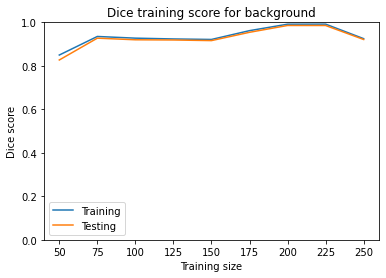

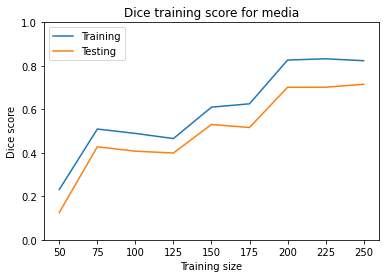

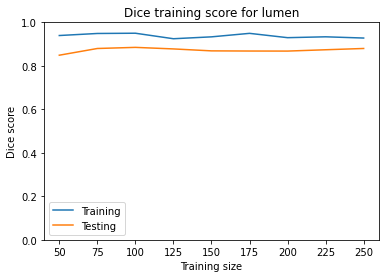

In [31]:
plt.figure()
for classname in classes:
    plt.plot(x, y_dice[classname], label="Training")
    plt.plot(x, y_test_dice[classname], label="Testing")
    plt.title(f"Dice training score for {classname}")
    plt.ylabel("Dice score")
    plt.xlabel("Training size")
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

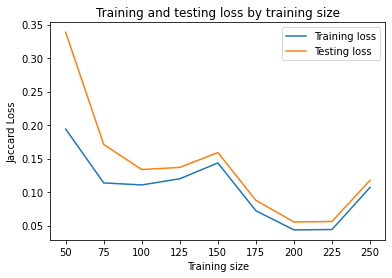

In [32]:
plt.figure()
plt.plot(x, y_loss, label="Training loss")
plt.plot(x, y_test_loss, label="Testing loss")
plt.title("Training and testing loss by training size")
plt.ylabel("Jaccard Loss")
plt.xlabel("Training size")
plt.legend()
plt.show()

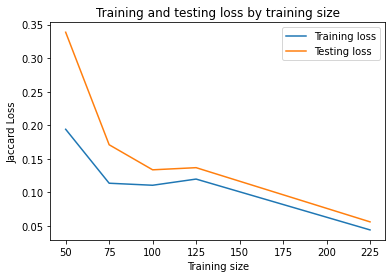

In [33]:
# Just take into account the following training sizes: [50, 75, 100, 125, 225]
x_ = [x[i] for i in [0, 1, 2, 3, 7]]
y_loss_ = [y_loss[i] for i in [0, 1, 2, 3, 7]]
y_test_loss_ = [y_test_loss[i] for i in [0, 1, 2, 3, 7]]

plt.figure()
plt.plot(x_, y_loss_, label="Training loss")
plt.plot(x_, y_test_loss_, label="Testing loss")
plt.title("Training and testing loss by training size")
plt.ylabel("Jaccard Loss")
plt.xlabel("Training size")
plt.legend()
plt.show()

In [34]:
plt.figure()
for training_size in training_sizes:
    plt.plot(data_by_training_size['data'][2][str(training_size)]['history']['val_loss'], label=f"Training size = {training_size}")
plt.title("Validation dice lumen for different training size values")
plt.ylabel("Dice score")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>